# Auto Encoder (AE) general workflow

In this note, using the same dataset as my note about Restricted Boltzmann Machine (RBM) ( http://nbviewer.jupyter.org/gist/p1c0sovm9DfTaw/e285868e9c4f3acecab48c3b0d77449a), I made the Auto Encoder (AE) which predicts the ratings of the movies that users have not watched. This AE makes predictions based on what users of similar taste have rated the movies which were not unrated by the user you are paying attention to, not based on specific features like genre tags, which can be implemented due to one of AE's characteristic that extracts (learns) features at the hidden layer(s) by dimension reduction. A more detailed and concise description is given at https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798.

## Intuitive description

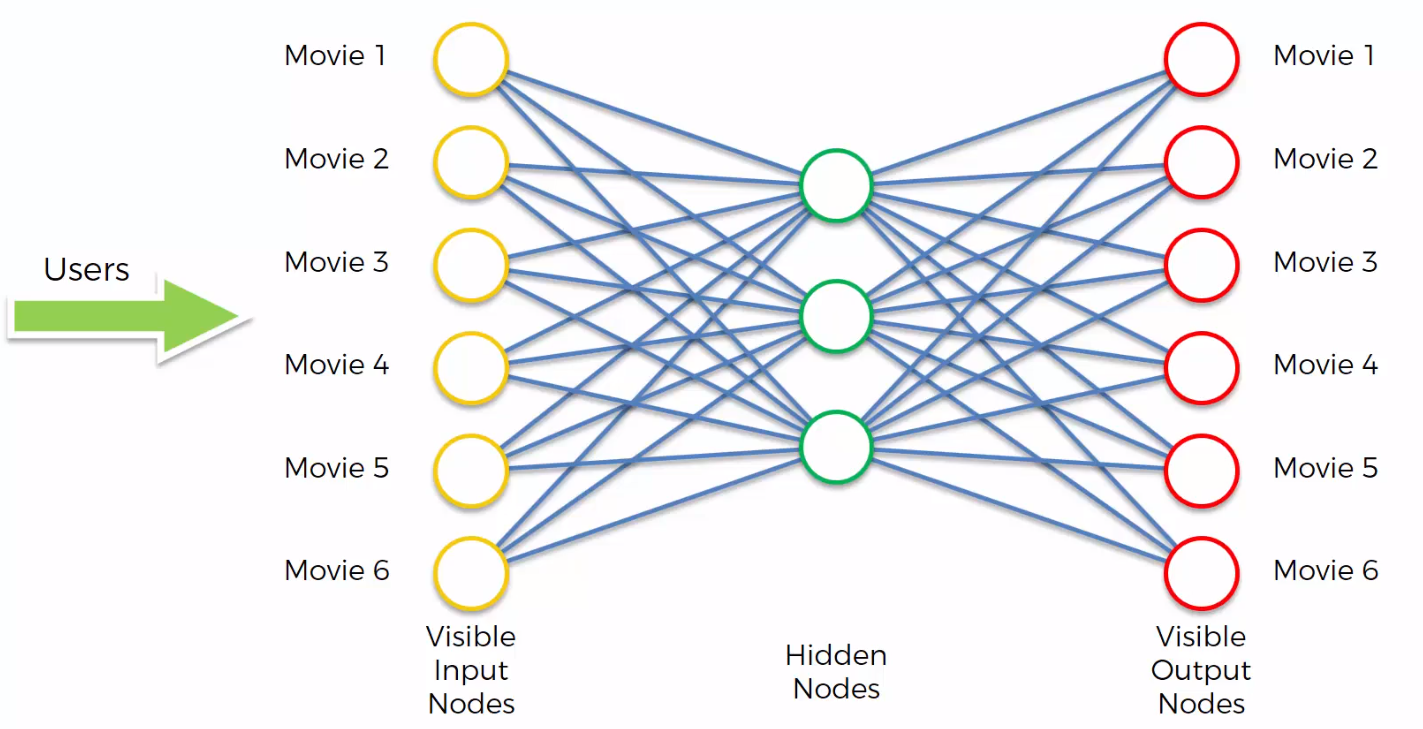

figure 1. intuitive image of Auto Encoder. source: superdatascience.com


In [21]:
from IPython.display import Image, display_jpeg, display_png
display_png(Image('autoencoder1.PNG'))
print('figure 1. intuitive image of Auto Encoder. source: superdatascience.com')

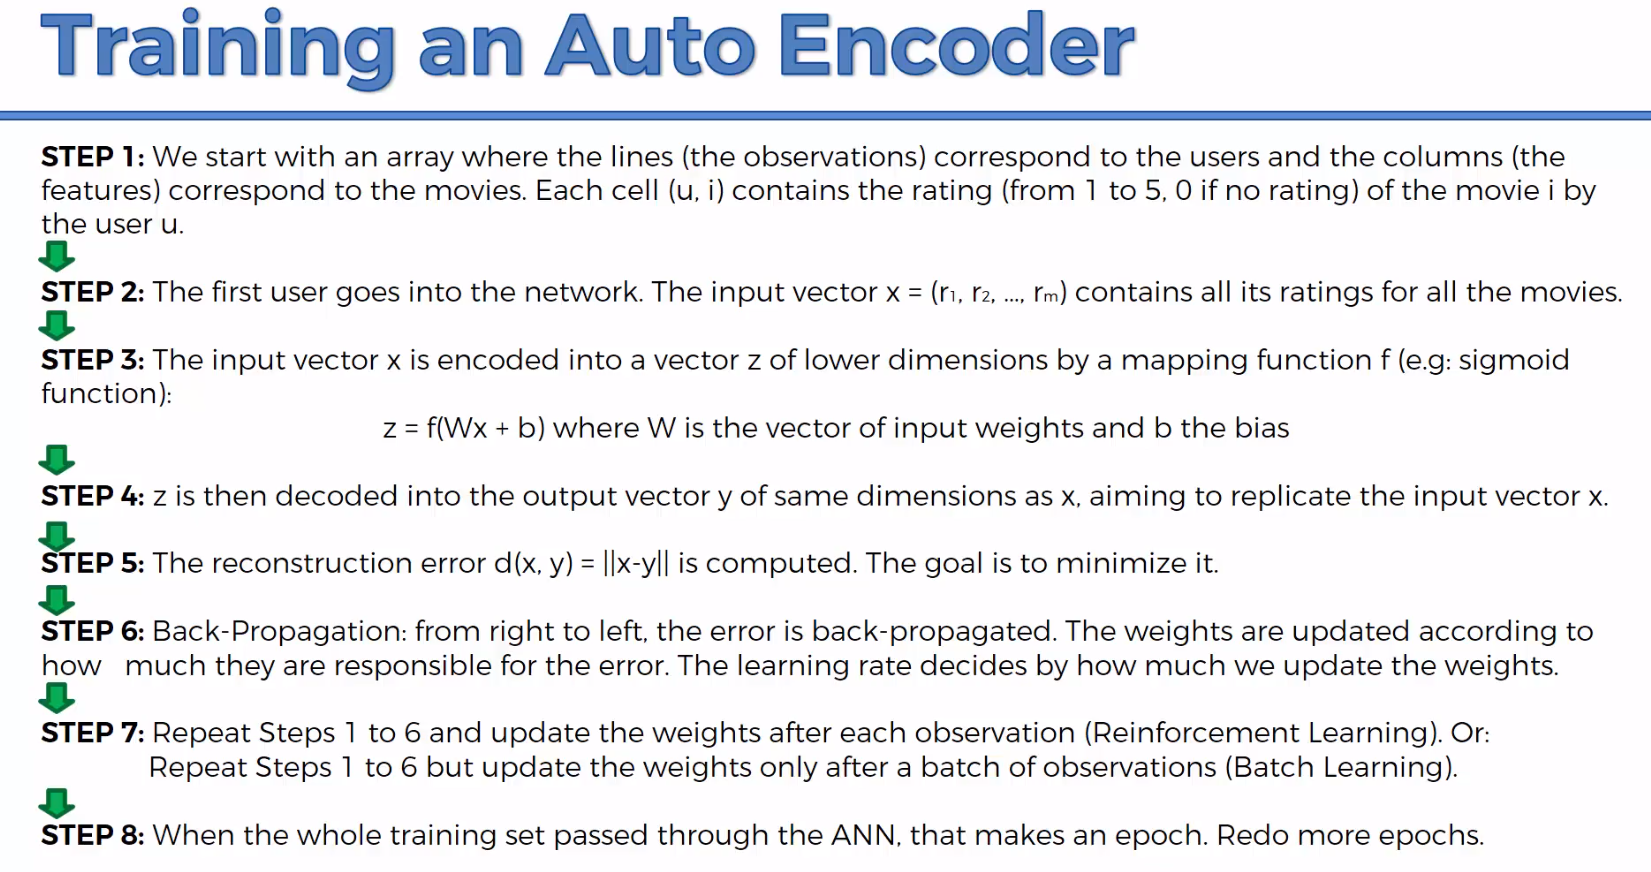

figure 2. Auto Encoder . source: superdatascience.com


In [24]:
from IPython.display import Image, display_jpeg, display_png
display_png(Image('autoencoder2.PNG'))
print('figure 2. Auto Encoder. source: superdatascience.com')

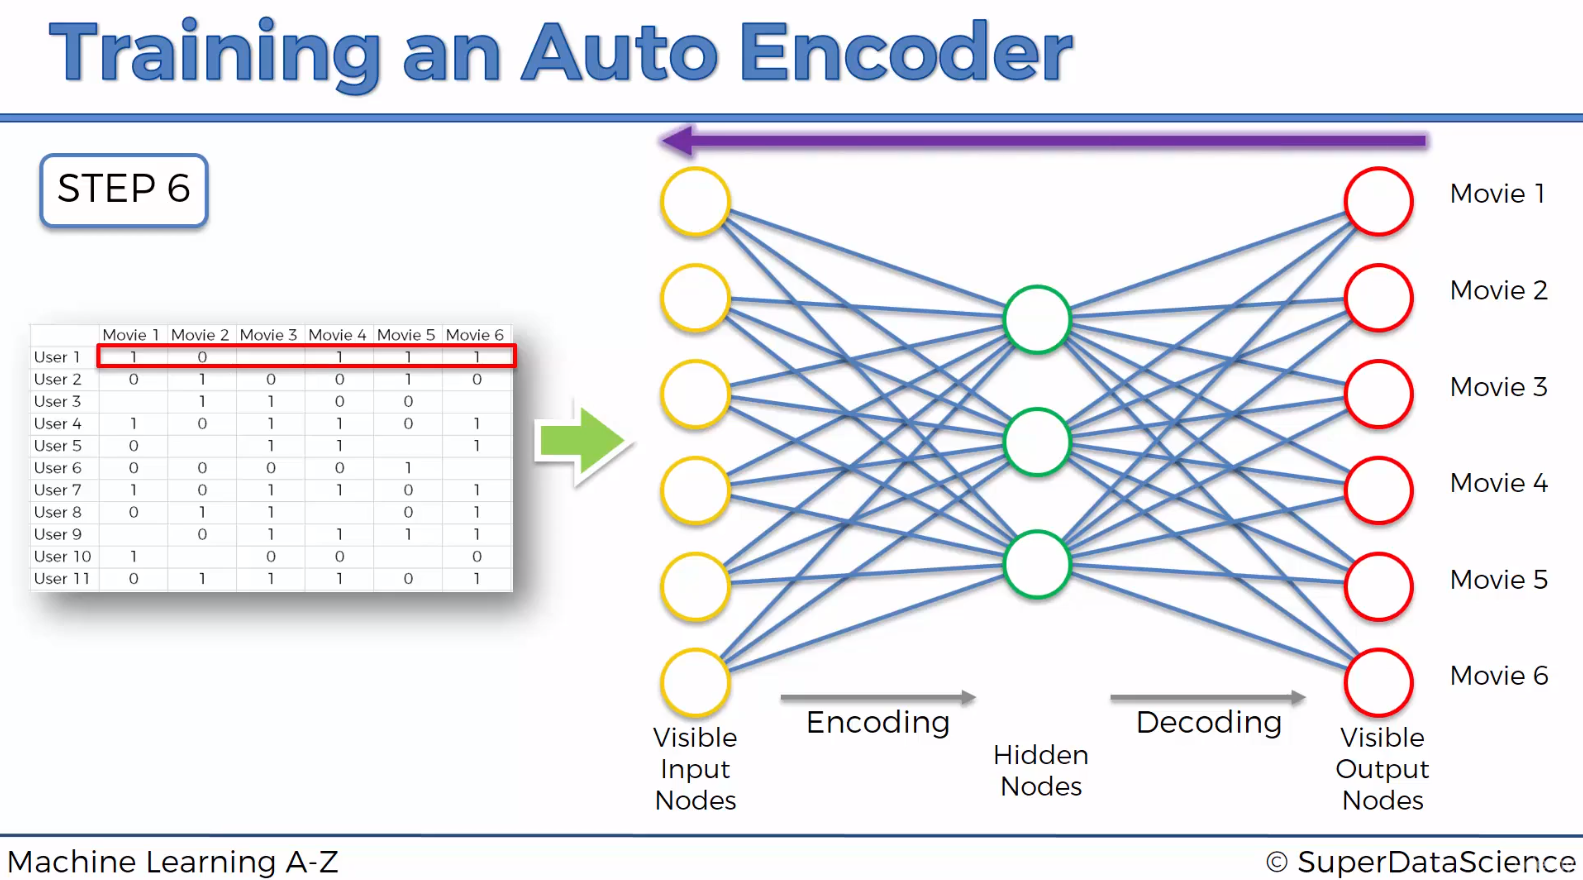

figure 3. Image of Step 6 at figure 2. source: superdatascience.com


In [26]:
from IPython.display import Image, display_jpeg, display_png
display_png(Image('autoencoder3.PNG'))
print('figure 3. Image of Step 6 at figure 2. source: superdatascience.com')

## Data import

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import time

######### these datasets were imported just to easily understand the data structure ###############
#import the dataset
movies = pd.read_csv('ml-1m/movies.dat', sep='::', header = None, engine = 'python', encoding = 'latin-1' )
users = pd.read_csv('ml-1m/users.dat', sep='::', header = None, engine = 'python', encoding = 'latin-1' )
ratings = pd.read_csv('ml-1m/users.dat', sep='::', header = None, engine = 'python', encoding = 'latin-1' )
###################################################################################################

print('movies.shape: {}'.format(movies.shape))
display(movies.head())
print('users.shape: {}'.format(users.shape))
display(users.head())
print('ratings.shape: {}'.format(ratings.shape))
display(ratings.head())

movies.shape: (3883, 3)


,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


users.shape: (6040, 5)


,0,1,2,3,4
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


ratings.shape: (6040, 5)


,0,1,2,3,4
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


## Data Preprocessing
#### This section is same as my note about Restricted Boltzmann Machine (RBM): http://nbviewer.jupyter.org/gist/p1c0sovm9DfTaw/e285868e9c4f3acecab48c3b0d77449a

In [10]:
#prepare the training and test dataset
training_set = pd.read_csv('ml-100k/u1.base', delimiter = '\t', header = None )
training_set_int = np.array(training_set, dtype='int') 
test_set = pd.read_csv('ml-100k/u1.test', delimiter = '\t', header = None )
test_set_int = np.array(test_set, dtype='int') 

print('training_set: user id, movie id, rating, evaluation (1 to 5), timestamp (not used)')
display(training_set[0:20])
print('test_set: user id, movie id, rating, evaluation (1 to 5), timestamp (not used)')
display(test_set[0:20])

#get the number of total users and movies
nb_users = int(max(max(training_set_int[:, 0]), max(test_set_int[:, 0])))
nb_movies = int(max(max(training_set_int[:, 1]), max(test_set_int[:, 1])))


training_set: user id, movie id, rating, evaluation (1 to 5), timestamp (not used)


,0,1,2,3
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712
5,1,7,4,875071561
6,1,8,1,875072484
7,1,9,5,878543541
8,1,11,2,875072262
9,1,13,5,875071805


test_set: user id, movie id, rating, evaluation (1 to 5), timestamp (not used)


,0,1,2,3
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198
5,1,20,4,887431883
6,1,23,4,875072895
7,1,24,3,875071713
8,1,27,2,876892946
9,1,31,3,875072144


#### From here, the process is different from my note about Restricted Boltzmann Machine (RBM)

In [4]:
print('nb_movies ',nb_movies)
print('nb_users ',nb_users)

#convert the data into an array with users in lines and movies in columns
def convertForTorchAe(data):
    new_data = []
    for id_users in range (1, nb_users + 1):
#        get the data only having the same user id as id_users 
        id_movies = data[:, 1][data[:, 0] == id_users]
        id_ratings = data[:, 2][data[:, 0] == id_users]
#         initialize all ratings to zero
        ratings = np.zeros(nb_movies)
    
#        only the index not having the ratings at id_ratings get 0. the element indeces are specifited by id_movies - 1, which keep all the ratings of the movies which are not evaluated as zero. 
        ratings[id_movies - 1] = id_ratings
#        torch package requires list of list 
        new_data.append(list(ratings))
    return new_data

training_set_converted = convertForTorchAe(training_set_int)
test_set_converted = convertForTorchAe(test_set_int)
print('np.array(training_set_converted).shape', np.array(training_set_converted).shape)
print('np.array(test_set_converted).shape', np.array(test_set_converted).shape)

#convert the data into torch tensors
training_set_torch = torch.FloatTensor(training_set_converted)
test_set_torch = torch.FloatTensor(test_set_converted)


nb_movies  1682
nb_users  943
np.array(training_set_converted).shape (943, 1682)
np.array(test_set_converted).shape (943, 1682)


In [5]:
#create the architecture of auto encoder NN
class StackedAutoEncoder (nn.Module):    
    def __init__(self, ):
#        call the constructor of the parent class
        super(StackedAutoEncoder, self).__init__()
#        define the connection (function) between the input layer and the first hidden layer
        self.fullConnection1 = nn.Linear(in_features=nb_movies, out_features=20)
        self.fullConnection2 = nn.Linear(in_features=20, out_features=10)
        self.fullConnection3 = nn.Linear(in_features=10, out_features=20)
        self.fullConnection4 = nn.Linear(in_features=20, out_features=nb_movies)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.fullConnection1(x))
        x = self.activation(self.fullConnection2(x))
        x = self.activation(self.fullConnection3(x))
        x = self.fullConnection4(x)
        return x

# auto encoder model instance
sae = StackedAutoEncoder()
# evaluation instance
criterion = nn.MSELoss()
# optimization instance
optimizer = optim.RMSprop(params = sae.parameters(), lr=0.01, weight_decay=0.5)

## Train the model

In [ ]:
#train the stacked auto encoder
nb_epoch = 200
#loop for epoch
for epoch in range (1, nb_epoch + 1):
    train_loss = 0
#    the number of users rating at least one movie (exclue the one giving no rating) 
    s = 0.
#    loop over each user
    for id_user in range (nb_users):
#         batch of a single input vector
        input = Variable(training_set_torch[id_user]).unsqueeze(0)
#        print('Variable(training_set_torch[id_user]): ', Variable(training_set_torch[id_user]))
#        print('input: ', input)
        target = input.clone()
#        print('target: ', target)
#        just eliminate the user having no rating
        if torch.sum(target.data > 0) > 0:
            output = sae.forward(input)
#            not update 'target' by gradient descent, which save a lot of computation cost.
            target.require_grad = False
#            not calculate the weight of the 0 ratings
            output[target == 0] = 0
#            calculate the lossfunction. Average of the differences.of the real rating and predicted rating
            loss = criterion(output, target)
#            print('loss: ', loss)
#            average of the error only considering the rated movies, not all of the movies. 1e-15 is added just to avoid 0 denominator.
            mean_corrector = nb_movies / float(torch.sum(target.data > 0) + 1e-15)
#            print('mean_corrector: ', mean_corrector)
#            calculate the backward, which decided the direction of updates (plus or minus) 
            loss.backward()
            train_loss += np.sqrt(loss.data[0] * mean_corrector)
            s += 1.
#            apply the optimizer, which decide the intensity (amount) of the backward update
            optimizer.step()        
#    if loss is 1, the difference between the prediction and the real ratings is 1 star. it is expected to be less than 1 at least.
    print('epoch: ' + str(epoch) + ' loss: ' + str(train_loss / s))

Since the loss function was less than 1.0, it was estimated the trained Auto Encoder would predict the movie ratings with the range of 0.9132989766486358 variance (if the movie recommends the one that the users have not watched but they will like (4.0 ratings), the actual ratings would be 4 ±0.9132989766486358).

## Test the model

#### By comparing the predicted output (ratings) generated by the training dataset with the real ratings from the test dataset (excluding the movie ratings that are not in the test dataset), the Auto Encoder is tested with the loss function  - how much the predicted ratings including the ratings to unwatched movies differ from the ratings which were not used for training.
#### The reason why it works is because the AE learns the features at the hidden layer(s) at the training due to the dimention reduction. Almost all users do not rate all movies, but most movies should be rated by someone, which makes the AE learn the similarity/difference between the users in terms of the rating tendency, which leads to extract features. Thus, at the test phase, the AE can also output the ratings of the movies that have not watched by each user, that is exacatly what we call prediction.
#### Lastly, since the test data contains only the ratings which are exclued in the training dataset as shown in the training and test data content, we can evaluate how accurately the AE made the prediction (or recommendation in this problem) by comparing with the test dataset for the movies that have not watched in the training dataset. 

In [12]:
test_loss = 0
#    the number of users rating at least one movie (exclue the one giving no rating) 
s = 0.
for id_user in range (nb_users):
    input = Variable(training_set_torch[id_user]).unsqueeze(0)
#     print('input: ', input)
    target = Variable(test_set_torch[id_user])
#     print('target: ', target)
#        just eliminate the user having no rating
    if torch.sum(target.data > 0) > 0:
        output = sae.forward(input)
#            print('output: ', output)
#            not update target by gradient descent
        target.require_grad = False
#            not calculate the weight of the 0 ratings, which enables to compare only theratings of the movies that useres watched in the target dataset but not in the training dataset. 
        output[target == 0] = 0
#            calculate the lossfunction. Average of the differences.of the real rating and predicted rating
        loss = criterion(output, target)
#            print('loss: ', loss)
#            average of the error only considering the rated movies, not all of the movies
        mean_corrector = nb_movies / float(torch.sum(target.data > 0) + 1e-15)
#            print('mean_corrector: ', mean_corrector)
#            calculate the backward, which decided the direction of updates (plus or minus) 
        test_loss += np.sqrt(loss.data[0] * mean_corrector)
        s += 1.
        
#    if loss is 1, the difference between the prediction and the real ratings is 1 star. it is expected to be less than 1 at least.
print('test loss: ' + str(test_loss / s))



test loss: 0.9574885469828647


From the test result, the loss wass less than 1., which means the AE predicted the ratings of the movies which the users have not watched with ±0.9574885469828647 mean squared error (MSE). It would not be a bad prediction.